TODAY

In [1]:
from datetime import datetime

# Get today's date in 'YYYY-MM-DD' format
today_date = datetime.today().strftime('%Y-%m-%d')
print(today_date)

2025-06-03


Finance Data

In [2]:
import yfinance as yf

# Define parameters
symbol = 'MSFT'
start_date = '2000-01-01'
end_date = today_date
output_filename = f'{symbol}_daily_data.csv'

# Download data (make sure to not pass a list)
data = yf.download(symbol, start=start_date, end=end_date, interval='1d')

# Reset index to make 'Date' a column
data.reset_index(inplace=True)

# Save to clean CSV
data.to_csv(output_filename, index=False)



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
import pandas as pd
df = pd.read_csv(output_filename)
# Remove the first row (header row mistakenly read as data)
df = df.iloc[1:].reset_index(drop=True)

# Save the cleaned dataframe back to CSV
df.to_csv(output_filename, index=False)

Training an LSTM Model with Stock Data

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

2025-06-03 04:18:09.995069: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 04:18:14.494286: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 04:18:15.800409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748924296.252799    2410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748924296.689369    2410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748924301.133001    2410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
# Load your CSV (must have 'Close' column)
df = pd.read_csv(output_filename)

# Ensure only numerical data
data = df[['Close']].dropna().values

In [6]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [7]:
# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 60  # e.g. 60 days
X, y = create_sequences(scaled_data, time_steps)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Train-test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Fine-tuned model architecture
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile with different optimizer and learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Enhanced callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001)
checkpoint = ModelCheckpoint('best_model_tuned.h5', save_best_only=True, monitor='val_loss')

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


/workspaces/Stock-Market-Prediction-AI-Model/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate
mae = mean_absolute_error(y_test_rescaled, predictions)
mse = mean_squared_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}')



Epoch 1/100


159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 6.2000e-05 - mae: 0.0051 - val_loss: 0.0103 - val_mae: 0.0906
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 8.3595e-05 - mae: 0.0062 - val_loss: 9.2379e-04 - val_mae: 0.0248
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 6.8573e-05 - mae: 0.0055 - val_loss: 0.0098 - val_mae: 0.0888
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - loss: 7.2255e-05 - mae: 0.0057 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 7.0331e-05 - mae: 0.0053 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 5.3960e-05 - mae: 0.0049 - val_loss: 0.0039 - val_mae: 0.0517
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 4.4305e-05 - mae: 0.0044 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - loss: 5.4619e-05 - mae: 0.0048 - val_loss: 0.0022 - val_mae: 0.0362


159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - loss: 5.6194e-05 - mae: 0.0048 - val_loss: 6.9168e-04 - val_mae: 0.0199
Epoch 16/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - loss: 5.1648e-05 - mae: 0.0047 - val_loss: 0.0027 - val_mae: 0.0420
Epoch 17/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - loss: 4.3547e-05 - mae: 0.0041 - val_loss: 0.0014 - val_mae: 0.0283
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
MAE: 11.2140, MSE: 189.4229, R²: 0.9699


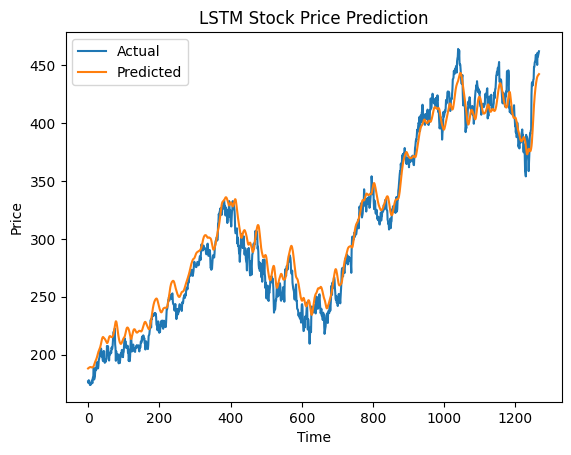

In [18]:
# Plot results
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()